# **Transfer Learning using MobileNetV2**

Transfer learning is a powerful technique that allows sophisticated CNNs trained by Google, Microsoft, and others on GPUs to be repurposed and used to solve domain-specific problems. Many pretrained CNNs are available in the public domain, and several are included with Keras. We chose to use MobileNetV2, a pretrained CNN from Google that is optimized for mobile devices, to extract features from spectrogram images.

*MobileNetV2 requires less processing power and has a smaller memory footprint than CNNs such as ResNet50V2. That's why it is ideal for mobile devices.*

> When applied to the test set, the model achieves an **accuracy** of **82%** and an **F1** (macro) **score** of **80%**, with 2.0-second segmentation and a batch size of 32.





## 1. Mount the Google Drive to the Colab environment

In [1]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/GitHub/MarineMammalSoundClassification/'
%cd /content/drive/My Drive/GitHub/MarineMammalSoundClassification/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1oJSL58N419Ve8pd0wCvgXEy52hLM2tJN/MarineMammalSoundClassification


## 2. Import the necessary libraries and scripts

In [2]:
import os
import numpy as np
import pickle
from utils.utilities import ensure_dir
from utils.models_functions import load_data, create_TL_model, train_model, evaluate_model, save_model, load_model
from utils.display import display_model_evaluation
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

## 3. Train and Εvaluate the Model

The architecture we chose for our model is the following:

1. **Base Model**: MobileNetV2
  * Pre-trained Weights: Uses weights pre-trained on ImageNet.
  * Include Top: Excludes the top (classification) layers.
  * Input Shape: Processes input images of size 224x224 with 3 color channels (RGB).
2. **Sequential Model Initialization**: Initializes a linear stack of layers including the base model.
3. **Flatten Layer**: Converts the output of the base model into a 1D vector.
4. **Dense Layer**: 1024 units with ReLU activation for learning complex features.
5. **Dropout Layer**: Sets 10% of input units to 0 to prevent overfitting.
6. **Dense Layer**: 512 units with ReLU activation for further feature learning.
7. **Output Layer**: num_classes units with softmax activation for classification.
8. **Freeze Base Model Layers**: All layers in the MobileNetV2 base model are frozen to retain the pre-trained weights during initial training.
9. **Model Compilation**: Uses Adam optimizer, categorical cross-entropy loss, and accuracy metric.

In order to prepare our input to match the input shape of MobileNetV2 (224, 224, 3) we use the following function which takes a spectrogram as input, resizes it to 224x224 pixels, and converts it to a 3-channel RGB image by stacking the single channel three times. The resulting image is scaled to the range 0-255.

In [3]:
def resize_and_convert_to_rgb(spectrogram):
    """
    Resize a spectrogram to 224x224 pixels and convert it to a 3-channel RGB image.

    Args:
        spectrogram (numpy.ndarray): The input spectrogram with shape (height, width).

    Returns:
        numpy.ndarray: The resized 3-channel RGB image with shape (224, 224, 3)
    """
    # Resize to 224x224
    resized_spec = cv2.resize(spectrogram, (224, 224))
    # Convert to 3 channels
    rgb_spec = np.stack([resized_spec] * 3, axis=-1)*255
    return rgb_spec

In [4]:
def process_pipeline(model_name, specs_or_mels, seg_secs, epochs=40, batch_size=64, patience=5):
    """
    Performs the entire pipeline of processing, training, evaluating, and saving a neural network model.

    Args:
    model_name (str): The name to be used for saving the model and HTML output.
    specs_or_mels (str): Specifies whether to use spectrograms or mel spectrograms.
    seg_secs (int): The segment duration in seconds for which data is prepared.
    epochs (int, optional): The number of epochs to train the model. Defaults to 40.
    batch_size (int, optional): The batch size to use during training. Defaults to 64.
    patience (int, optional): The number of epochs with no improvement after which training will be stopped. Defaults to 5.

    Returns:
    None
    """
    # Load the data
    specs_path = f'spectrograms/{seg_secs}_secs/train_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/train_classes.pkl'

    trainX, trainY, _ = load_data(specs_path, classes_path, True)
    trainX = np.array([resize_and_convert_to_rgb(x) for x in trainX])
    trainX = preprocess_input(trainX)

    specs_path = f'spectrograms/{seg_secs}_secs/val_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/val_classes.pkl'

    valX, valY, _ = load_data(specs_path, classes_path, True)
    valX = np.array([resize_and_convert_to_rgb(x) for x in valX])
    valX = preprocess_input(valX)

    # Build the model
    num_classes = len(trainY[0])
    model = create_TL_model(num_classes)
    history = train_model(model, trainX, trainY, valX, valY, epochs, batch_size, patience)

    # Create directory for saving models if it doesn't exist
    ensure_dir('models/TL')

    # Save the trained model
    model_path = os.path.join('models/TL', model_name+'.keras')
    save_model(model, model_path)

    # Load the saved model
    loaded_model = load_model(model_path)

    # Load test data and evaluate the model
    specs_path = f'spectrograms/{seg_secs}_secs/test_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/test_classes.pkl'

    testSegments_path = f'spectrograms/{seg_secs}_secs/test_segments.pkl'
    with open(testSegments_path, 'rb') as f:
        testSegments = np.array(pickle.load(f))


    testX, testY, encoder = load_data(specs_path, classes_path, True)
    testX = np.array([resize_and_convert_to_rgb(x) for x in testX])
    testX= preprocess_input(testX)
    conf_matrix, accuracy, f1, majority_conf_matrix, majority_accuracy, majority_f1 = evaluate_model(loaded_model, testX, testY, testSegments)
    labels = list(encoder.classes_)

    display_model_evaluation('TL', f'input_type = {specs_or_mels} | seg_duration = {seg_secs}secs | epochs = {epochs} | batch_size = {batch_size} | patience = {patience}',\
                          history.history, accuracy, f1, conf_matrix, labels, True, majority_conf_matrix, majority_accuracy, majority_f1)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/60
469/469 [==============================] - 29s 46ms/step - loss: 2.3502 - accuracy: 0.6618 - val_loss: 1.9137 - val_accuracy: 0.4941 - lr: 0.0010
Epoch 2/60
469/469 [==============================] - 19s 40ms/step - loss: 0.8694 - accuracy: 0.7375 - val_loss: 1.5947 - val_accuracy: 0.5889 - lr: 0.0010
Epoch 3/60
469/469 [==============================] - 19s 40ms/step - loss: 0.7036 - accuracy: 0.7753 - val_loss: 1.4759 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 4/60
469/469 [==============================] - 19s 40ms/step - loss: 0.5969 - accuracy: 0.7987 - val_loss: 1.5197 - val_accuracy: 0.6206 - lr: 0.0010
Epoch 5/60
469/469 [==============================] - 18s 39ms/step - loss: 0.5327 - accuracy: 0.8166 - val_loss: 1.7280 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 6/60
469/469 [==============================] - 19s 40ms/step - loss: 0.4844 - accuracy: 0.8238 - val_loss: 1.5453 - val_accuracy: 0.6798 - lr: 0.

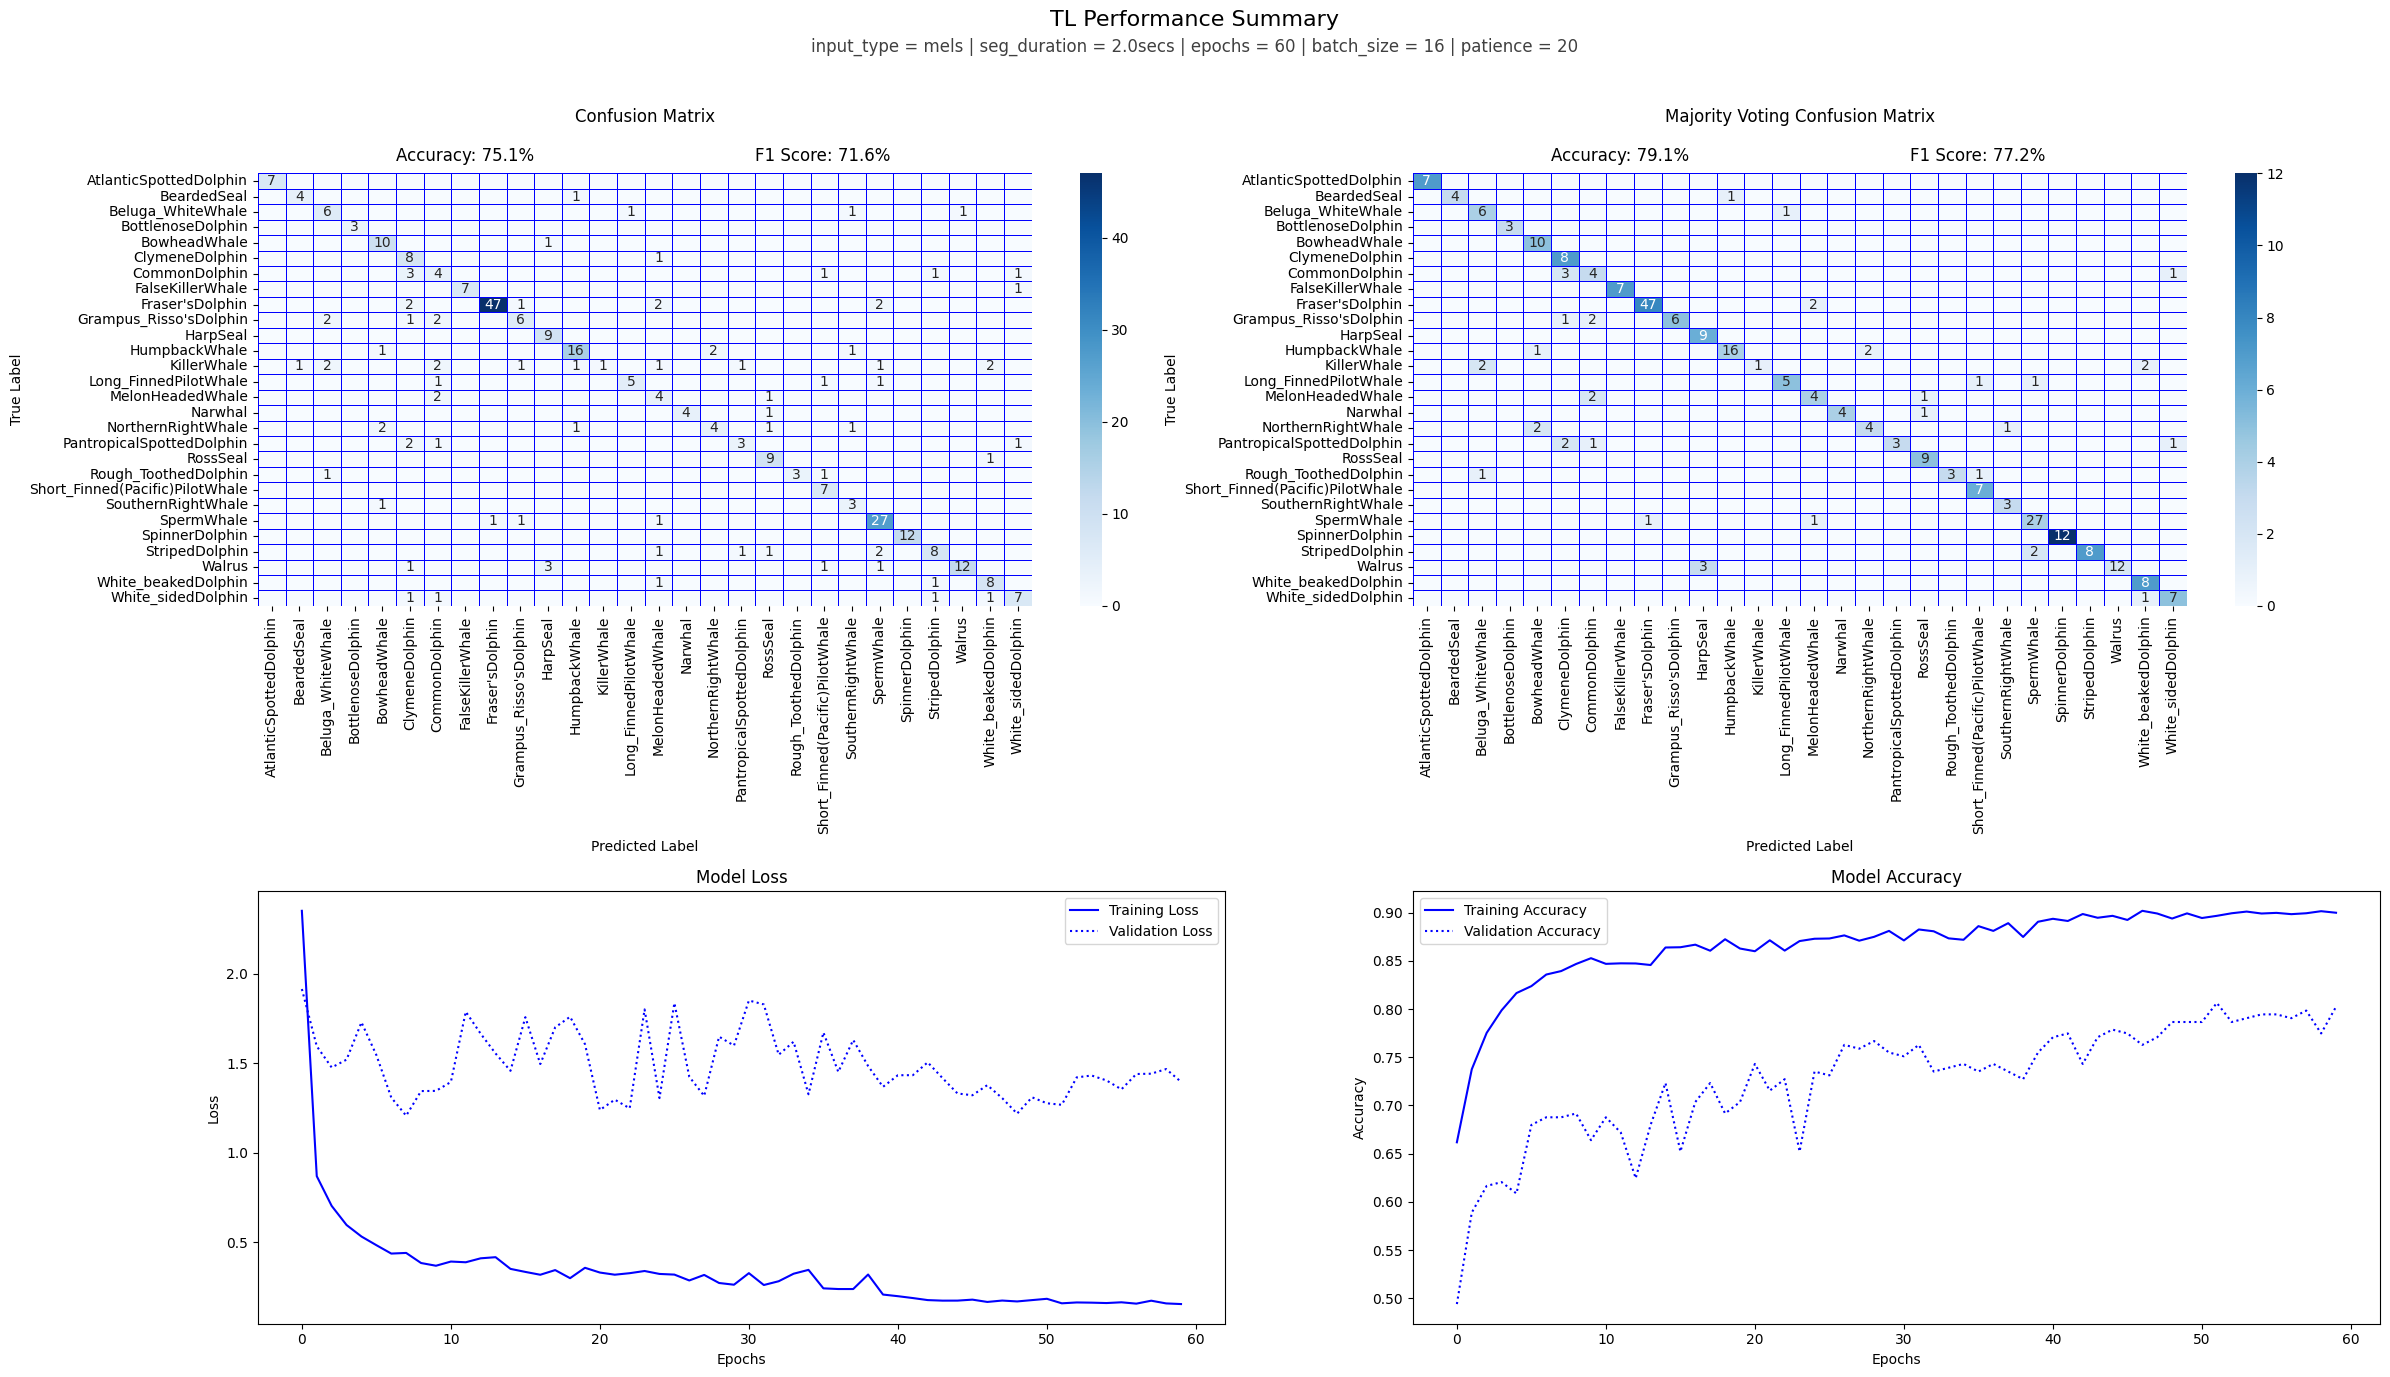

In [ ]:
process_pipeline('mels_2.0_60_16_20', 'mels', '2.0', 60, 16, 20)

Epoch 1/60
235/235 [==============================] - 20s 70ms/step - loss: 2.7170 - accuracy: 0.6714 - val_loss: 1.4770 - val_accuracy: 0.5415 - lr: 0.0010
Epoch 2/60
235/235 [==============================] - 14s 59ms/step - loss: 0.6456 - accuracy: 0.7806 - val_loss: 1.5332 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 3/60
235/235 [==============================] - 14s 59ms/step - loss: 0.5630 - accuracy: 0.8075 - val_loss: 1.3073 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 4/60
235/235 [==============================] - 14s 60ms/step - loss: 0.4692 - accuracy: 0.8255 - val_loss: 1.3514 - val_accuracy: 0.6561 - lr: 0.0010
Epoch 5/60
235/235 [==============================] - 14s 59ms/step - loss: 0.3709 - accuracy: 0.8449 - val_loss: 1.1756 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 6/60
235/235 [==============================] - 14s 58ms/step - loss: 0.3897 - accuracy: 0.8454 - val_loss: 1.5212 - val_accuracy: 0.6561 - lr: 0.0010
Epoch 7/60
235/235 [==============================] - 14s 

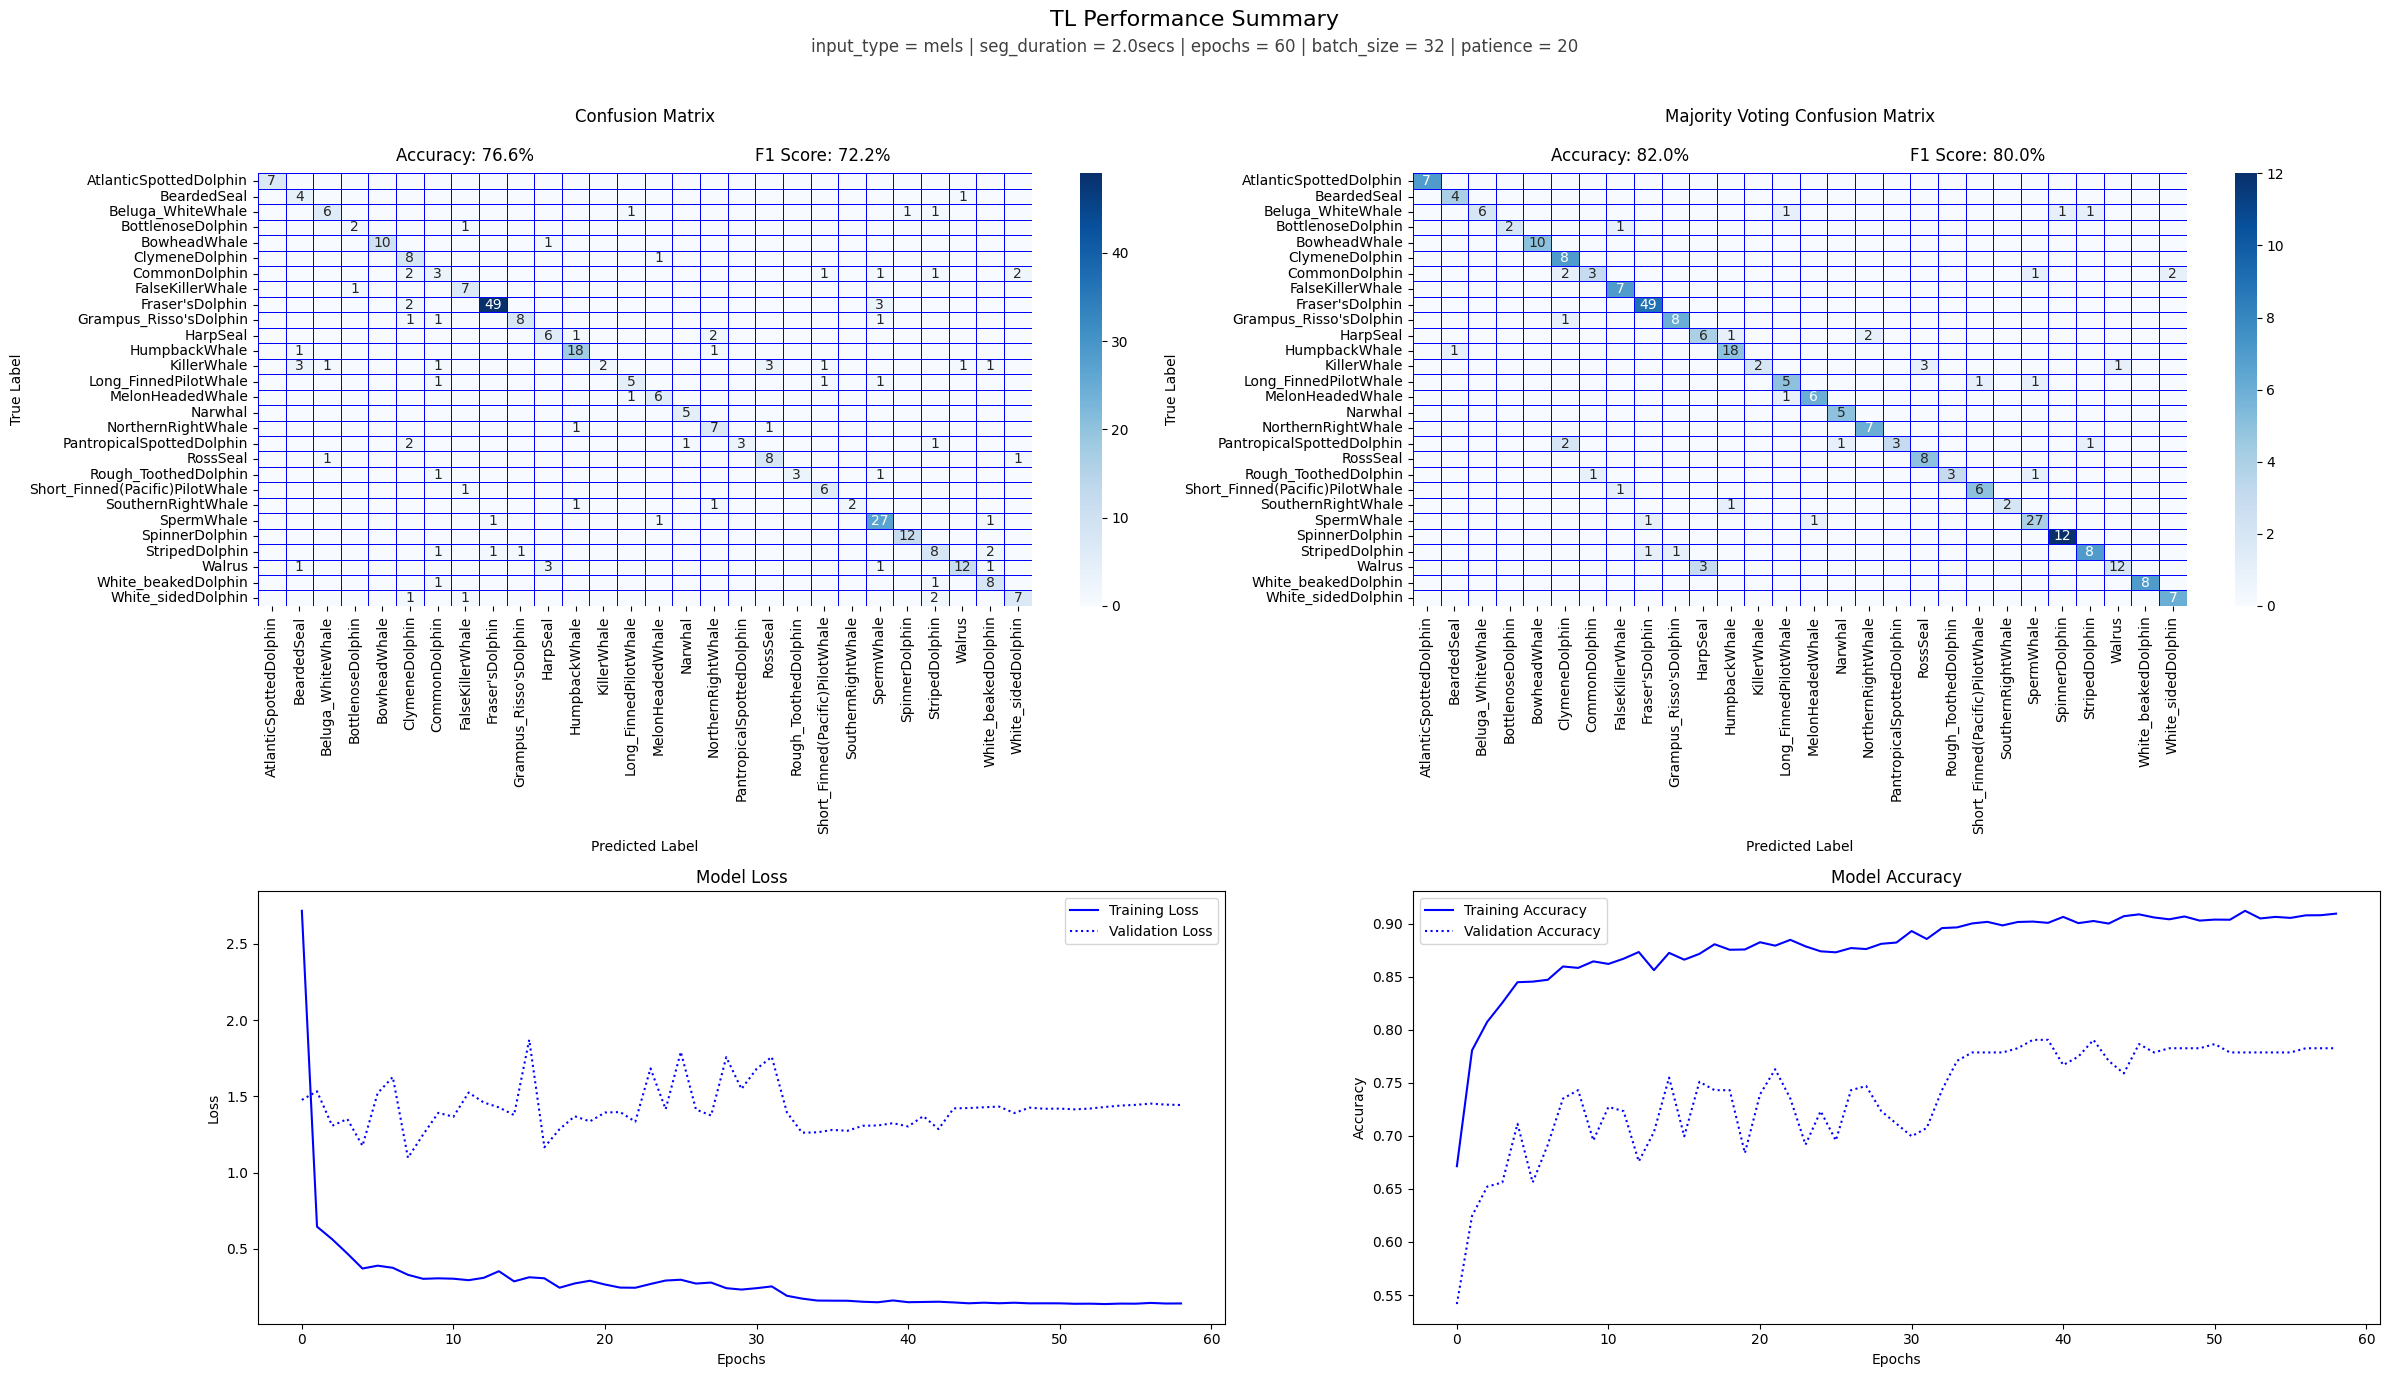

In [ ]:
process_pipeline('mels_2.0_60_32_20', 'mels', '2.0', 60, 32, 20)

Epoch 1/60
118/118 [==============================] - 19s 120ms/step - loss: 4.4689 - accuracy: 0.6479 - val_loss: 1.6534 - val_accuracy: 0.5731 - lr: 0.0010
Epoch 2/60
118/118 [==============================] - 12s 98ms/step - loss: 0.6324 - accuracy: 0.7904 - val_loss: 1.0765 - val_accuracy: 0.6996 - lr: 0.0010
Epoch 3/60
118/118 [==============================] - 11s 95ms/step - loss: 0.4198 - accuracy: 0.8414 - val_loss: 1.3251 - val_accuracy: 0.6443 - lr: 0.0010
Epoch 4/60
118/118 [==============================] - 11s 95ms/step - loss: 0.3410 - accuracy: 0.8577 - val_loss: 1.1716 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 5/60
118/118 [==============================] - 12s 98ms/step - loss: 0.3287 - accuracy: 0.8589 - val_loss: 1.2092 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 6/60
118/118 [==============================] - 11s 95ms/step - loss: 0.2904 - accuracy: 0.8668 - val_loss: 1.4487 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 7/60
118/118 [==============================] - 12s

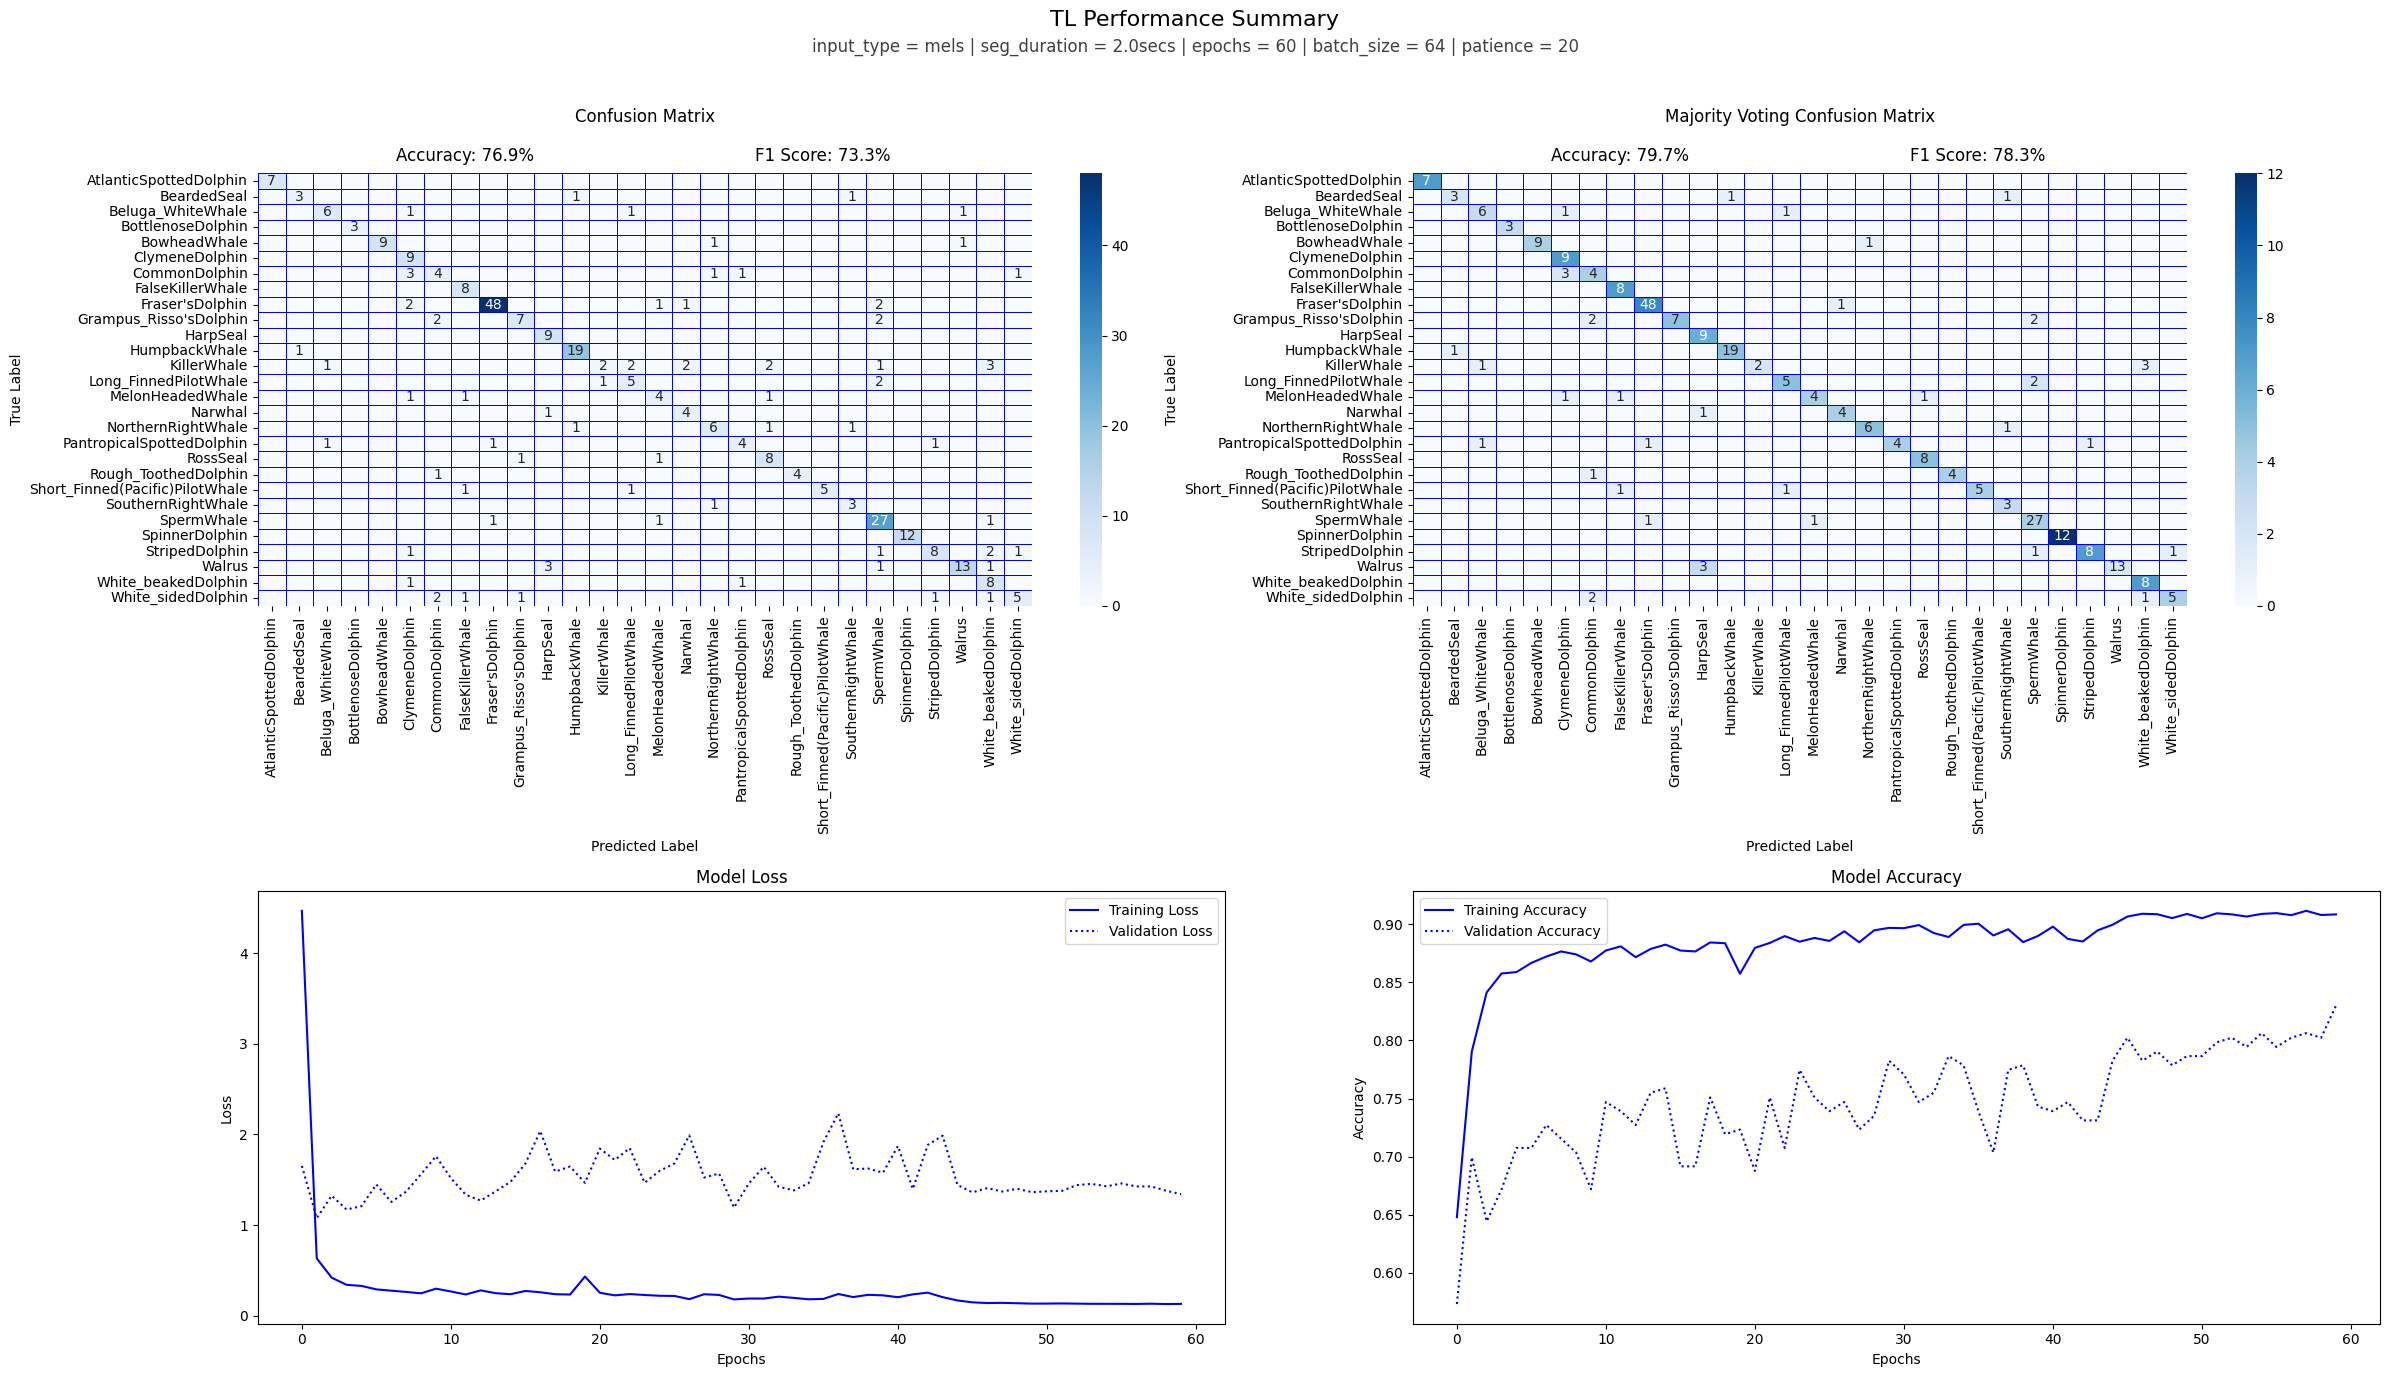

In [ ]:
process_pipeline('mels_2.0_60_64_20', 'mels', '2.0', 60, 64, 20)

Epoch 1/60
223/223 [==============================] - 14s 47ms/step - loss: 4.0305 - accuracy: 0.5844 - val_loss: 1.8474 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 2/60
223/223 [==============================] - 9s 41ms/step - loss: 0.8989 - accuracy: 0.7340 - val_loss: 1.5433 - val_accuracy: 0.5749 - lr: 0.0010
Epoch 3/60
223/223 [==============================] - 9s 41ms/step - loss: 0.6976 - accuracy: 0.7772 - val_loss: 1.3209 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 4/60
223/223 [==============================] - 9s 41ms/step - loss: 0.6082 - accuracy: 0.7996 - val_loss: 1.1735 - val_accuracy: 0.6826 - lr: 0.0010
Epoch 5/60
223/223 [==============================] - 9s 40ms/step - loss: 0.5062 - accuracy: 0.8248 - val_loss: 1.1421 - val_accuracy: 0.6886 - lr: 0.0010
Epoch 6/60
223/223 [==============================] - 9s 39ms/step - loss: 0.4901 - accuracy: 0.8299 - val_loss: 1.4546 - val_accuracy: 0.6407 - lr: 0.0010
Epoch 7/60
223/223 [==============================] - 9s 38ms/s

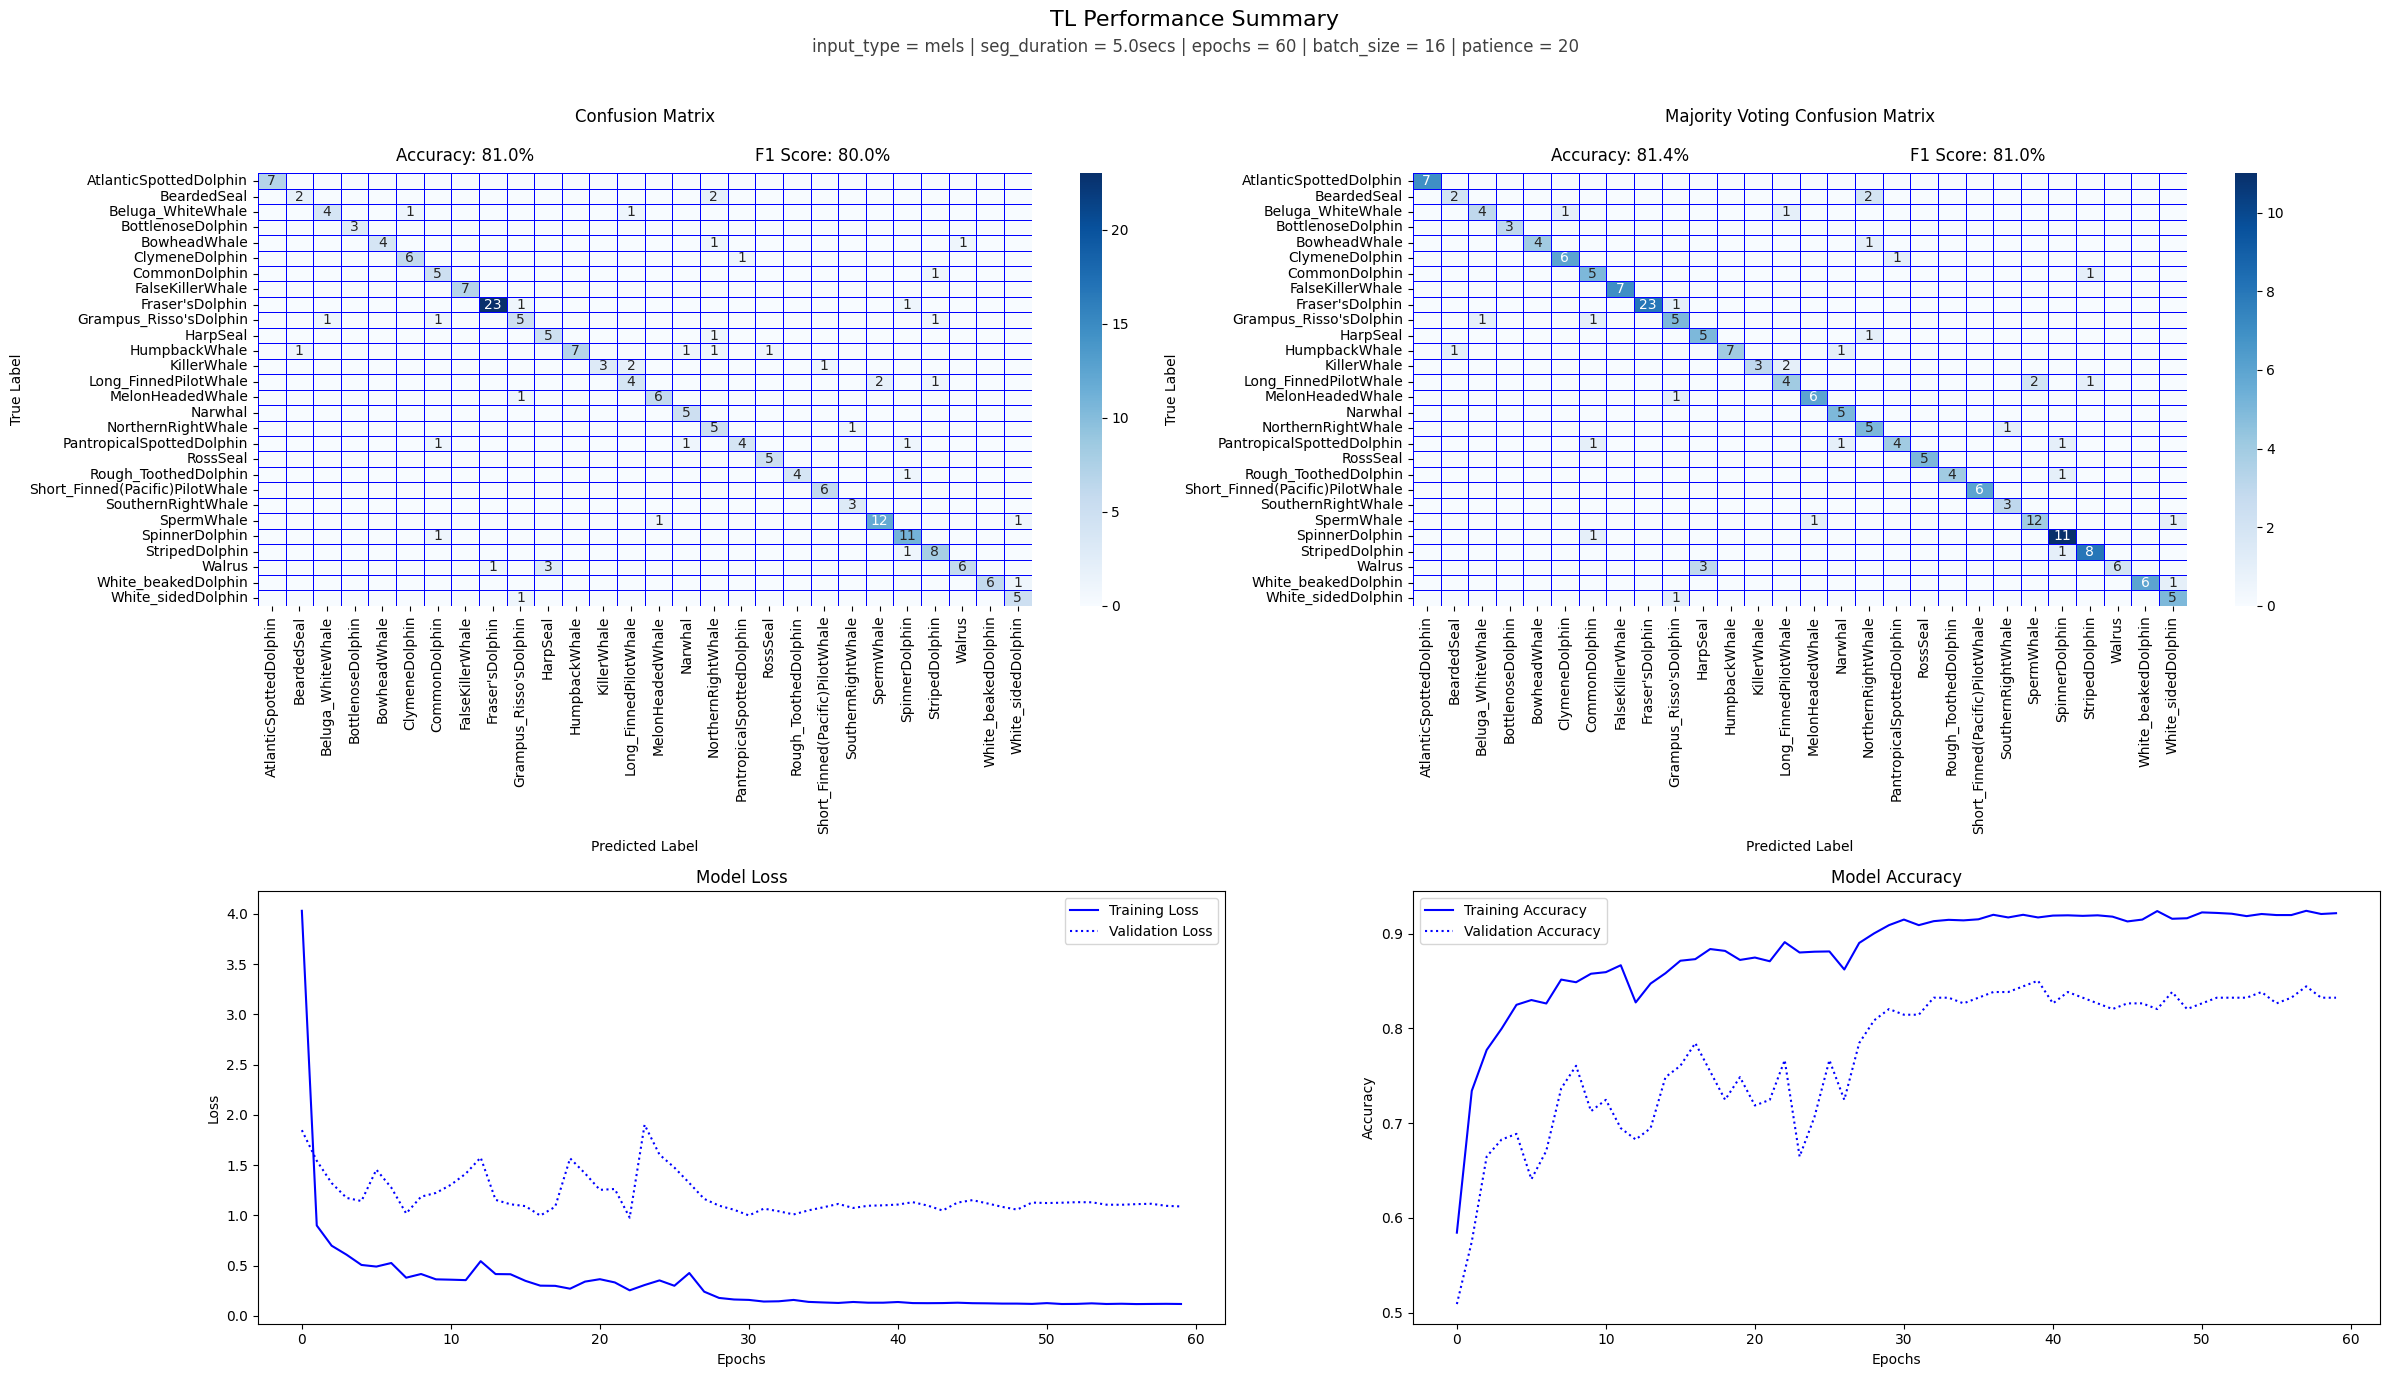

In [6]:
process_pipeline('mels_5.0_60_64_20', 'mels', '5.0', 60, 16, 20)

9406464/9406464 [==============================] - 2s 0us/step
Epoch 1/60
112/112 [==============================] - 18s 92ms/step - loss: 5.4076 - accuracy: 0.5788 - val_loss: 1.6356 - val_accuracy: 0.5449 - lr: 0.0010
Epoch 2/60
112/112 [==============================] - 7s 63ms/step - loss: 0.7992 - accuracy: 0.7626 - val_loss: 1.2579 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 3/60
112/112 [==============================] - 7s 64ms/step - loss: 0.6074 - accuracy: 0.8061 - val_loss: 1.1644 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 4/60
112/112 [==============================] - 7s 63ms/step - loss: 0.5332 - accuracy: 0.8206 - val_loss: 1.2657 - val_accuracy: 0.7305 - lr: 0.0010
Epoch 5/60
112/112 [==============================] - 7s 60ms/step - loss: 0.4904 - accuracy: 0.8352 - val_loss: 1.2676 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 6/60
112/112 [==============================] - 7s 60ms/step - loss: 0.4872 - accuracy: 0.8386 - val_loss: 1.4169 - val_accuracy: 0.7186 - lr: 0.0010


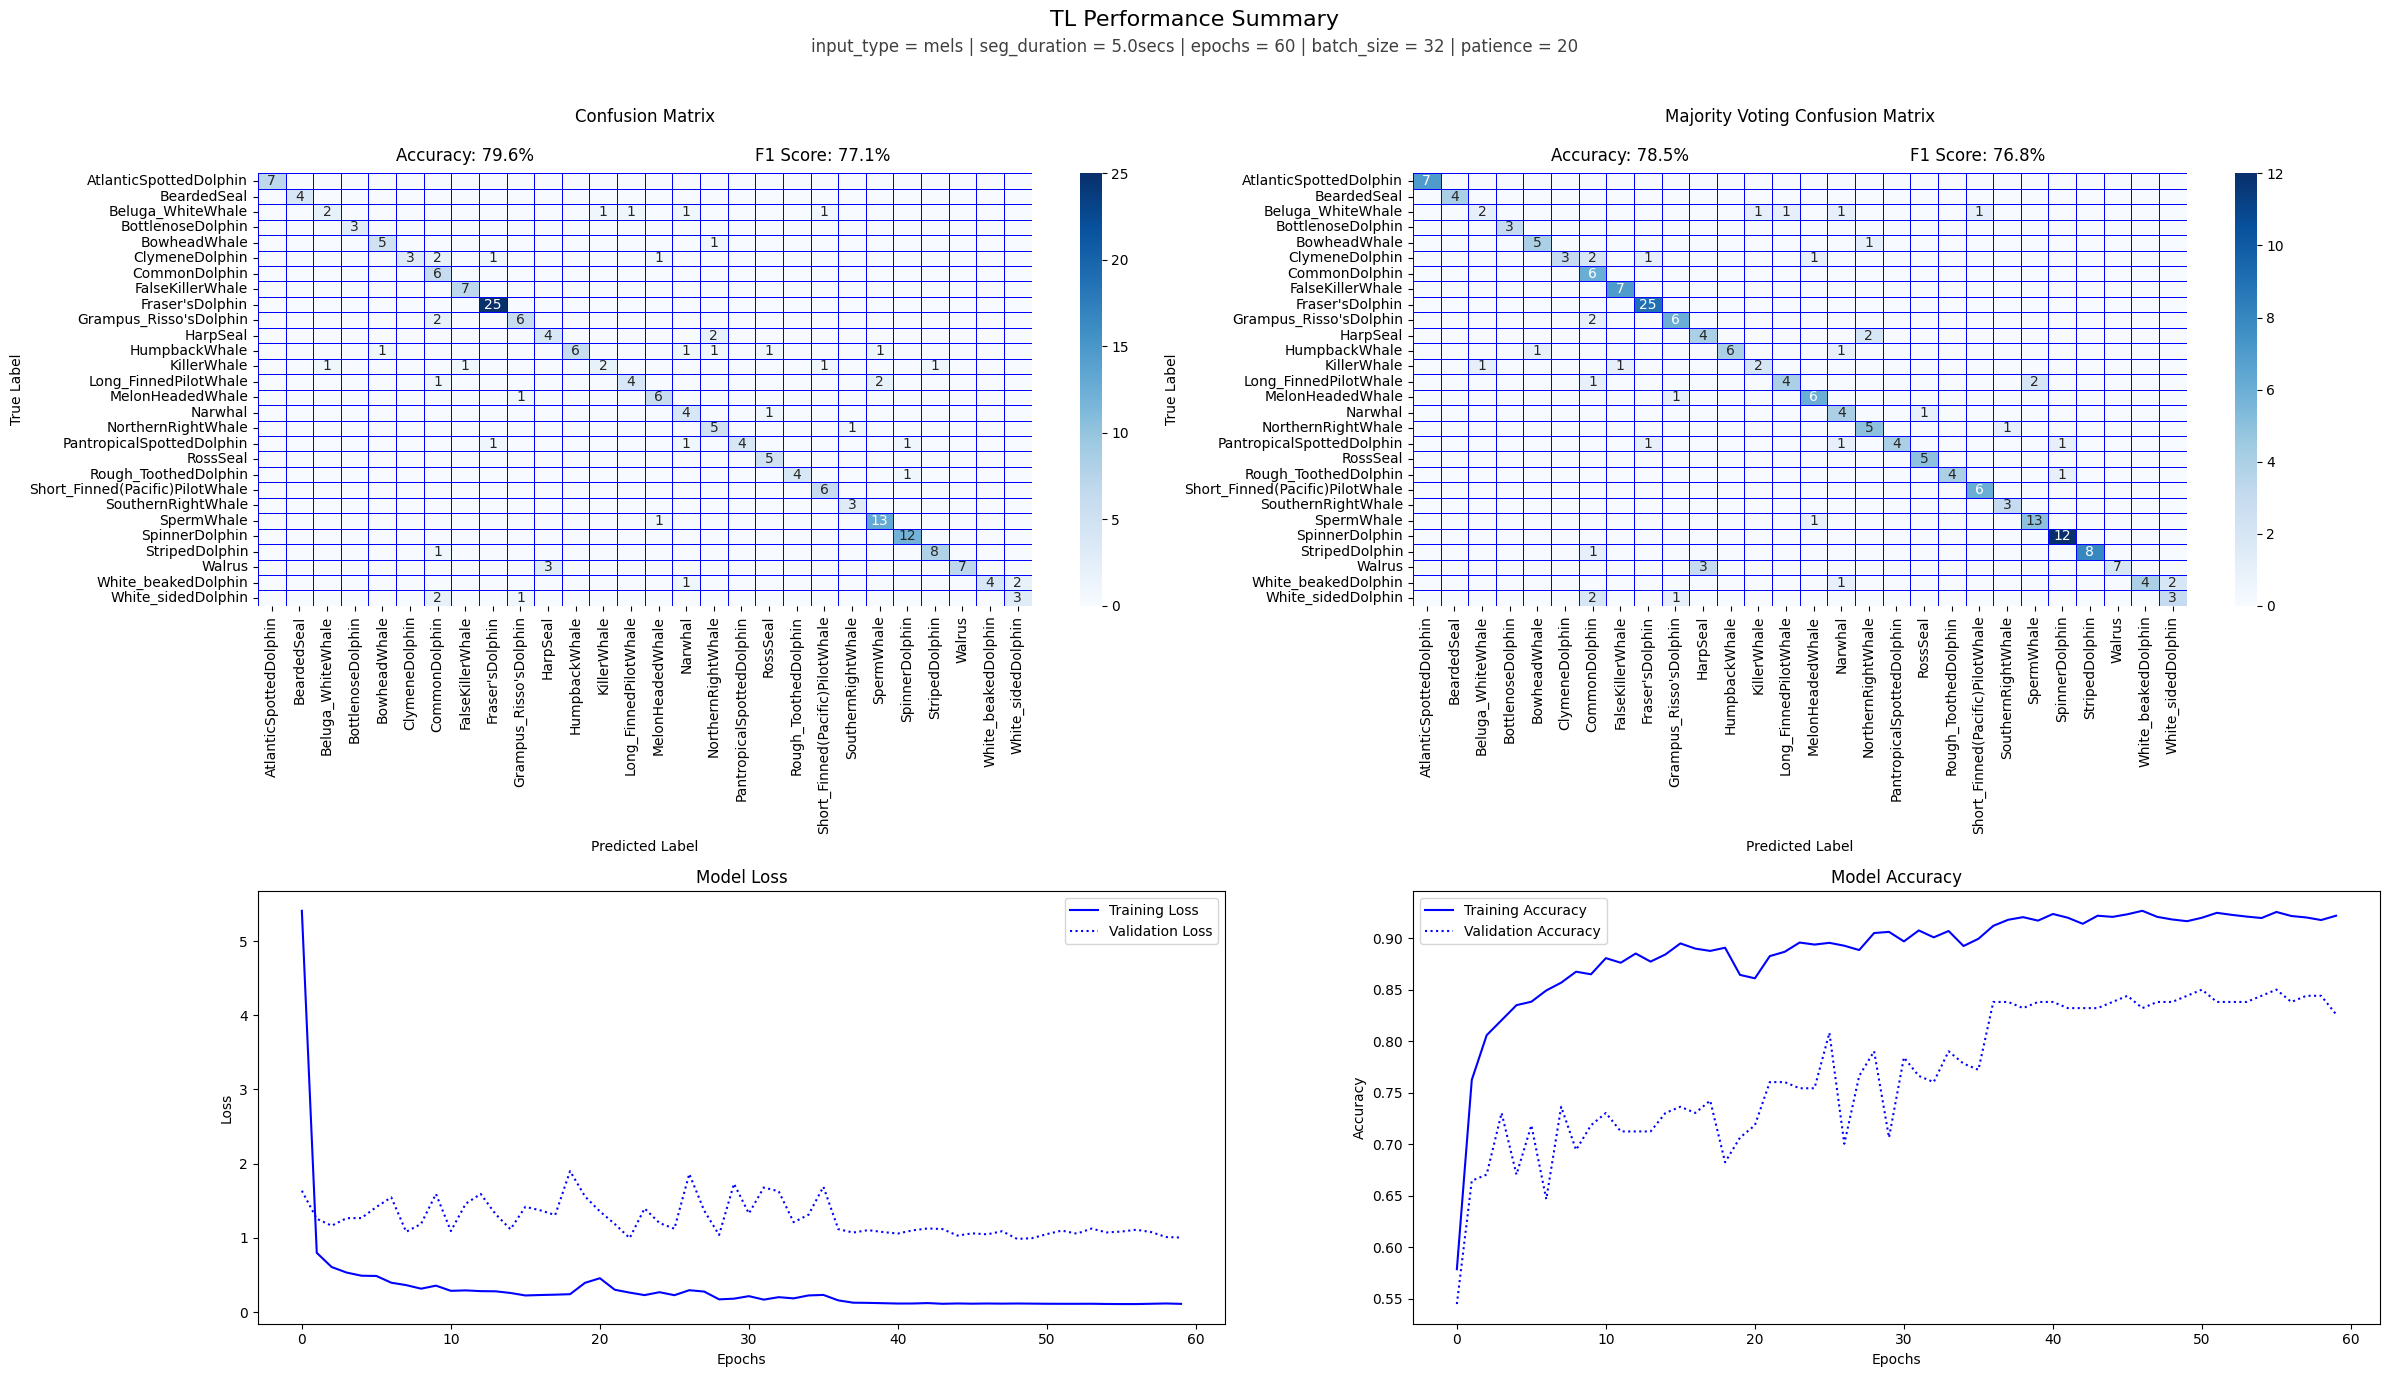

In [5]:
process_pipeline('mels_5.0_60_32_20', 'mels', '5.0', 60, 32, 20)